# Film dosimetry

## Prerequisites


* A minimum distance of 5 mm between films.
* Rectangular films aligned to the sides of the scanner.
* The tif image should have three channels, red, blue and green (RGB).
* 

This is a common example for film calibration. 

![example scanned films](../assets/cal_example_v2.png)

Optional

Optical filters are added as a quality control test for error detection. Useful if auto correction of color or brightness has been applied unconsciously. Also, as a way to measure inter-scan reproducibility of the lamp/detector system.

## Usage

Start importing the load funtion and LUT class.

In [1]:
from Dosepy.image import load
from Dosepy.calibration import LUT

Read the tiff file for film calibration

In [2]:
path_to_file = "/home/luis/Dosepy/tests/unit/fixtures/CAL20241106_001.tif"

cal_image = load(path_to_file)

Create a LUT object with the image as argument.

In [3]:
cal = LUT(cal_image)

Object num. 1
Object num. 2
Object num. 3
Object num. 4
Object num. 5
Object num. 6
Object num. 7
Object num. 8
Object num. 9
Object num. 10
Object num. 11


Dosepy automatically detects and enumerates each object in the image.

Create central rois on each film and show.

<Axes: >

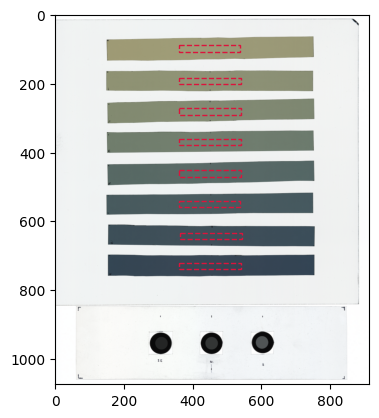

In [4]:
cal.set_central_rois()

cal.plot_rois()

Change the ROI size to 16 x 8 mm

<Axes: >

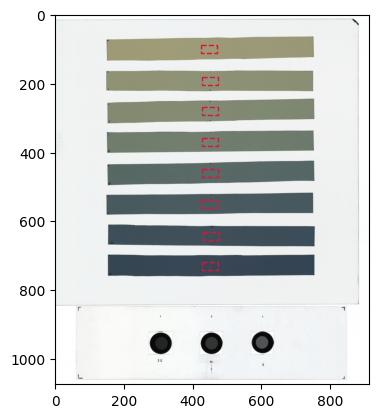

In [5]:
cal.set_central_rois(size = (16, 8))
cal.plot_rois()

In [6]:
type(cal_image.array[0,0,0])

numpy.uint16

To set-up the **cal** object we need to perform the following steps:

* Set the imparted doses to the films [Gy].
* Compute the lut 
* Optional, apply a filer of size of 3 pixels for noise reduction.

In [7]:

cal.set_doses([0, 0.5, 1, 2, 4, 6, 8, 10])

cal.compute_central_lut(filter=3)

## Show results

Plot the calibration curve, using the red channel and a rational function

$$ y = -c + \frac{b}{x-a} $$

where $$ x = \frac{I_0}{I} $$ represents the film response as the quotient of intensities of unexposed and exposed film, respectively.

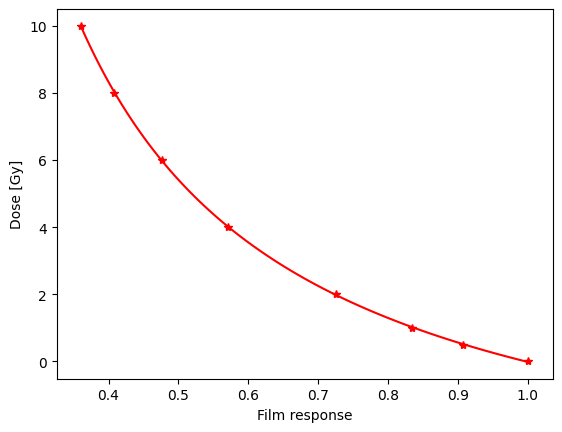

In [8]:
cal.plot_fit(fit="rational", channel="red")

Plot dose uncertainty with **plot_dose_fit_unertainty** method

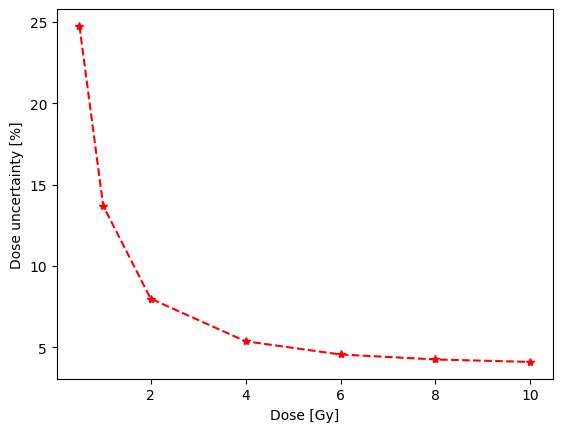

In [9]:
cal.plot_dose_fit_uncertainty(fit="rational", channel = "red")

## Lateral correction

Correction for lateral response artifact is done by computing a calibration curve at every milimeter in lateral direction. 

To set-up the lut, we need to load a relative dose profile of the field used for film irradiation. In this example, a 6 MV beam of size 150 mm x 150 mm, 5 mm deep was used for film calibration. 

The file must have an array of two columns:

* First column should be for positions, given in mm, with 0 being at center.

* Second column should be the relative values [%], normalized to 100 at center.

Object num. 1
Object num. 2
Object num. 3
Object num. 4
Object num. 5
Object num. 6
Object num. 7
Object num. 8
Object num. 9
Object num. 10
Object num. 11


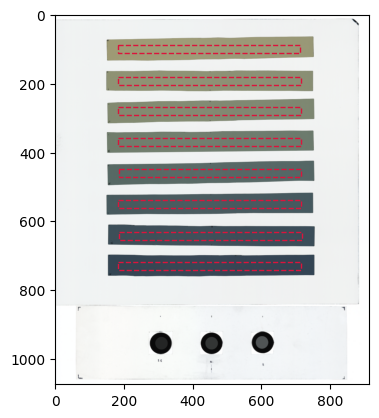

In [10]:
cal = LUT(cal_image)

cal.set_central_rois(size = (180, 8))
cal.set_doses([0, 0.5, 1, 2, 4, 6, 8, 10])
cal.plot_rois()

cal.set_beam_profile("/home/luis/Dosepy/tests/unit/fixtures/CAL/BeamProfile.csv")

Next we need to call the **compute_lateral_lut()** (instead of compute_central_lut())

In [11]:
cal.compute_lateral_lut(filter=3)

(Optional) show green intensity values on lateral direction

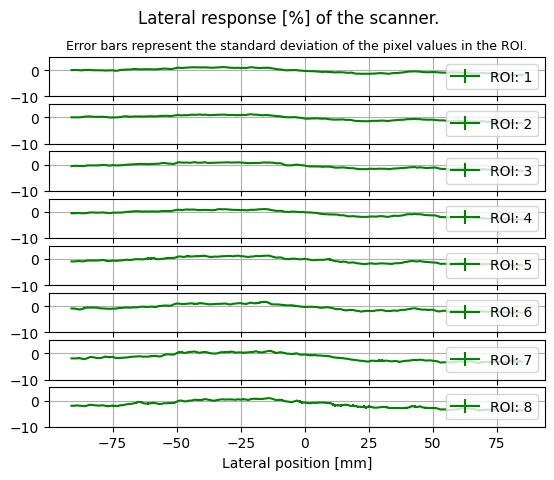

In [12]:
cal.plot_lateral_response(channel="green")

We can use the green channel and a polynomial fit function of the form

$$  y = ax + bx^n $$

_get_dose_from_fit
calib_response
[-0.          0.02505817  0.04714712  0.0877384   0.16429744  0.22839677
  0.28568504  0.34049264]


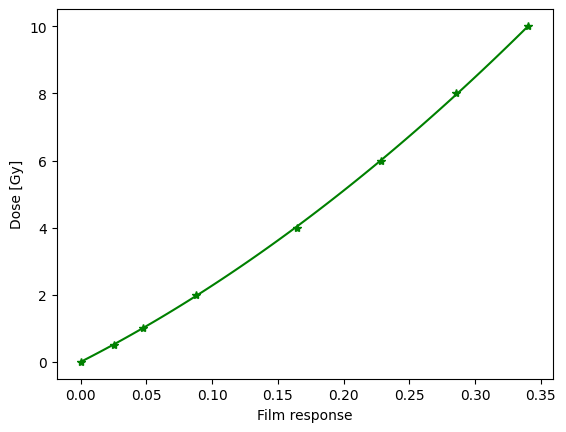

In [13]:
cal.plot_fit("polynomial", "green")

Show uncertainty at center

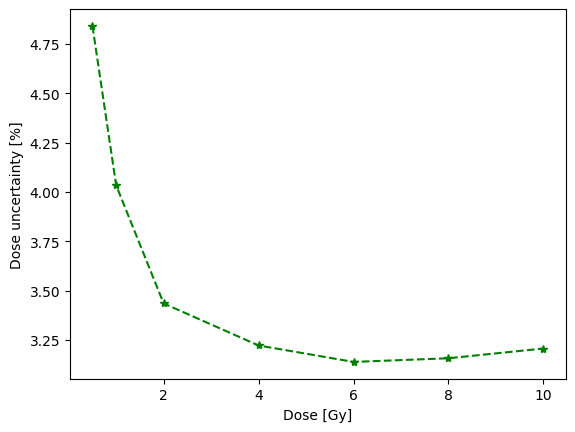

In [14]:
cal.plot_dose_fit_uncertainty(position=0, fit="polynomial", channel="green")

## Load multiple files for noise reduction

In [15]:
from Dosepy.image import load_multiples

In [16]:
files = [
    "/media/luis/TOMO/Tiff Films/EBT4/6NOV24_CAL/CAL20241106_001.tif",
    "/media/luis/TOMO/Tiff Films/EBT4/6NOV24_CAL/CAL20241106_002.tif",
    "/media/luis/TOMO/Tiff Films/EBT4/6NOV24_CAL/CAL20241106_003.tif",
]

img_m = load_multiples(files)

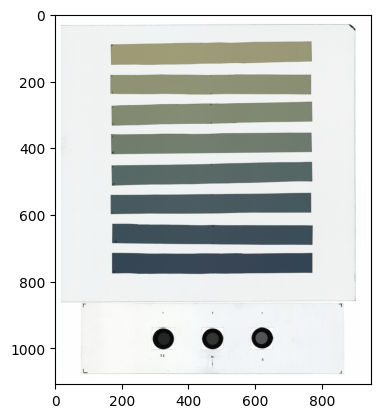

<Axes: >

In [17]:
img_m.plot()

Object num. 1
Object num. 2
Object num. 3
Object num. 4
Object num. 5
Object num. 6
Object num. 7
Object num. 8
Object num. 9
Object num. 10
Object num. 11


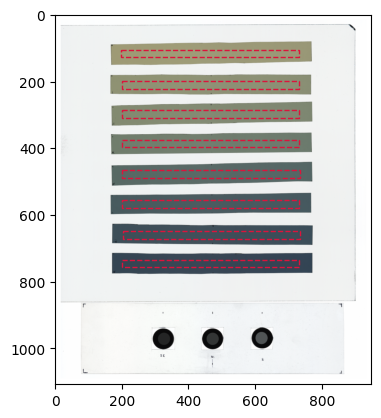

In [18]:
cal = LUT(img_m)

cal.set_central_rois(size = (180, 8))
cal.set_doses([0, 0.5, 1, 2, 4, 6, 8, 10])

cal.plot_rois()

cal.set_beam_profile("/home/luis/Dosepy/tests/unit/fixtures/CAL/BeamProfile.csv")

cal.compute_lateral_lut(filter=3)

_get_dose_from_fit
calib_response
[-0.          0.02507801  0.04699625  0.08786961  0.16451731  0.22861155
  0.28597919  0.34012119]


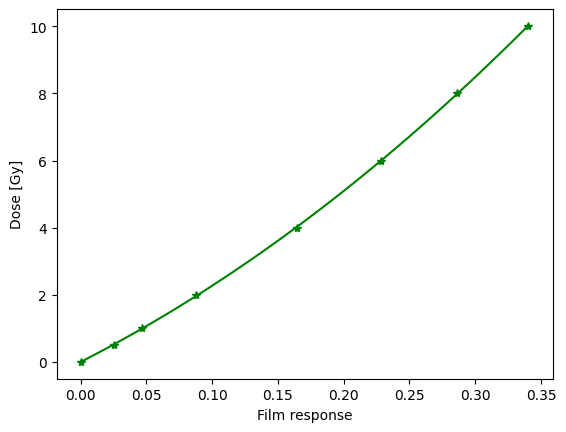

In [19]:
cal.plot_fit("polynomial", "green")

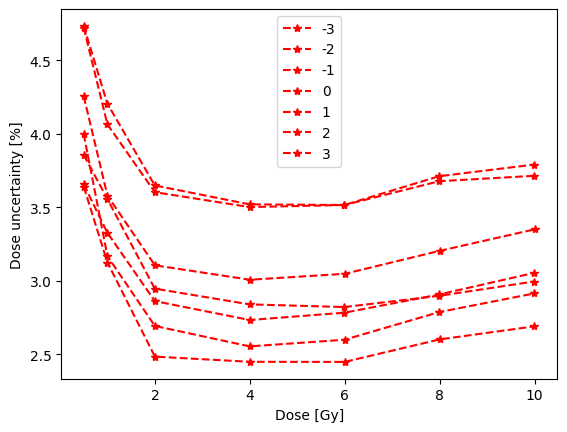

In [48]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for position in [-3, -2, -1, 0, 1, 2, 3]:
    cal.plot_dose_fit_uncertainty(
        position = position,
        fit="polynomial",
        channel="red",
        ax=ax,
        label=f"{position}"
        )

ax.legend()

In [21]:
# Clear memory
del img_m, cal_image

## Quality control using optical filters

TODO

## Film to dose

The next image is going to be used for verification. It was irradiated with 5.0 Gy.

Note

Additionaly to the film to be transformed to dose, the scanned image must also have one unirradiated film. It is used as a reference for 0 Gy.


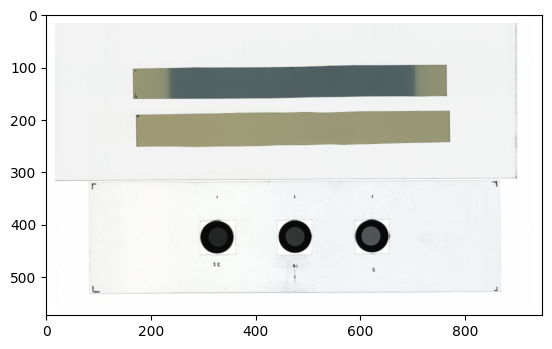

<Axes: >

In [31]:
# Load the images

files = [
    "/media/luis/TOMO/Tiff Films/EBT4/Verif 15x15/Ver_050dpi20241106_001.tif",
    "/media/luis/TOMO/Tiff Films/EBT4/Verif 15x15/Ver_050dpi20241106_002.tif",
    "/media/luis/TOMO/Tiff Films/EBT4/Verif 15x15/Ver_050dpi20241106_003.tif",
]

qa_image = load_multiples(files)
qa_image.plot()

In [23]:
""" import numpy
qa_image.array = (qa_image.array * 1.07).astype(numpy.uint16)
type(qa_image.array[0,0,0]) """

numpy.uint16

In [32]:
from Dosepy.calibration import passed_QC

passed_QC(img=qa_image, lut=cal)

Object num. 1
Object num. 2
Object num. 3
Object num. 4
Object num. 5


True

Import the tiff to dose manager. Use "RP" for red channel and a polynomial fit function.

In [33]:
from Dosepy.tiff2dose import Tiff2DoseM

t2d = Tiff2DoseM()

dose = t2d.get_dose(
    img=qa_image,
    format="RP",
    lut=cal
    )

Object num. 1
Object num. 2
Object num. 3
Object num. 4
Object num. 5
Inside RedPolynomialDoseConverter.get_zero_dose_intensity method


Plot the dose distribution

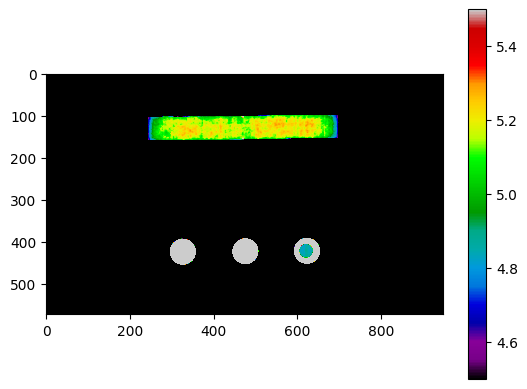

In [34]:
import matplotlib.pyplot as plt
import numpy as np


fig, ax = plt.subplots()
axeI = ax.imshow(
    dose.array,
    cmap="nipy_spectral",
    vmin=4.5,
    vmax=5.5)

fig.colorbar(axeI, ax=ax)

Save the dose distribution as a tif file (in cGy) useful for further analysis using [ImageJ](https://imagej.net/ij/).

In [35]:
dose.save_as_tif("dose_in_tif_file")

In [30]:
0.15/5*100

3.0

In [29]:
40070/40354*100

99.2962283788472